In [49]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import pandas as pd

np.random.seed(1234)

In [50]:
data = pd.read_excel('laplace_data.xlsx')

In [51]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [52]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [53]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([5.0], requires_grad=True).to(device)
        #self.lambda_2 = torch.tensor([5.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        #self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        #self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        #lambda_2 = self.lambda_2
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_xx + lambda_1* u_tt
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item()
                    #self.lambda_2.item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item()
                        #self.lambda_2.item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [54]:
T = np.array(data['Y']).flatten()[:,None]
X = np.array(data['X']).flatten()[:,None]
Exact = np.array(data['u_pred']).flatten()[:,None]

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

N_u = 1000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)  
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

It: 0, Loss: 1.383e+00, Lambda_1: 4.999
It: 100, Loss: 2.871e-01, Lambda_1: 4.871
It: 200, Loss: 8.036e-02, Lambda_1: 4.727
It: 300, Loss: 4.369e-02, Lambda_1: 4.687
It: 400, Loss: 3.621e-02, Lambda_1: 4.661
It: 500, Loss: 3.171e-02, Lambda_1: 4.634
It: 600, Loss: 2.863e-02, Lambda_1: 4.606
It: 700, Loss: 2.671e-02, Lambda_1: 4.573
It: 800, Loss: 2.470e-02, Lambda_1: 4.538
It: 900, Loss: 2.288e-02, Lambda_1: 4.501
It: 1000, Loss: 2.119e-02, Lambda_1: 4.464
It: 1100, Loss: 1.978e-02, Lambda_1: 4.425
It: 1200, Loss: 1.864e-02, Lambda_1: 4.385
It: 1300, Loss: 1.735e-02, Lambda_1: 4.346
It: 1400, Loss: 1.659e-02, Lambda_1: 4.302
It: 1500, Loss: 2.904e-02, Lambda_1: 4.261
It: 1600, Loss: 1.509e-02, Lambda_1: 4.215
It: 1700, Loss: 1.429e-02, Lambda_1: 4.172
It: 1800, Loss: 1.401e-02, Lambda_1: 4.124
It: 1900, Loss: 1.340e-02, Lambda_1: 4.083
It: 2000, Loss: 1.716e-02, Lambda_1: 4.033
It: 2100, Loss: 1.274e-02, Lambda_1: 3.992
It: 2200, Loss: 1.232e-02, Lambda_1: 3.949
It: 2300, Loss: 1.228e-

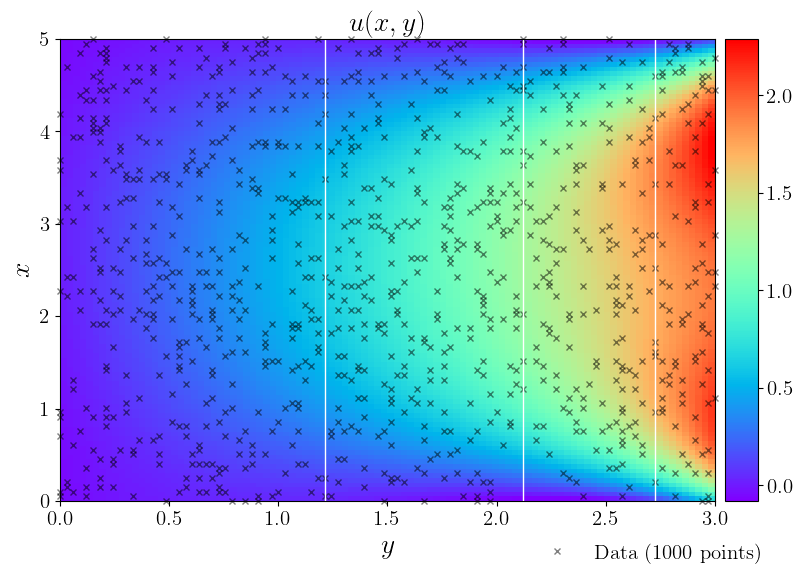

In [59]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    
x = np.linspace(0,5,100)
t = np.linspace(0,3,100)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[40]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[70]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[90]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$y$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(x,y)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.savefig("laplace_inverse.pdf", format="pdf")

plt.show()

In [60]:
Exact = Exact.reshape(100,100)
U_pred = U_pred.reshape(100,100)

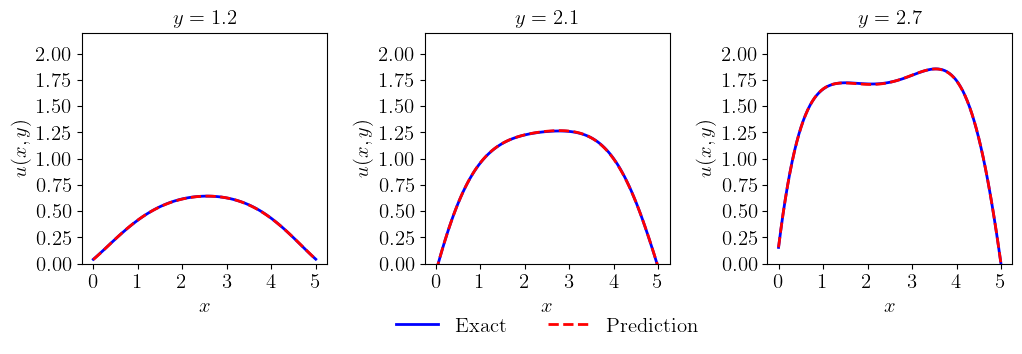

In [61]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(12, 3))
#ax = fig.add_subplot(111)
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.4)

plot1 = plt.subplot(gs[0, 0])
plot1.plot(x,Exact[40,:], 'b-', linewidth = 2, label = 'Exact')       
plot1.plot(x,U_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
plot1.set_xlabel('$x$')
plot1.set_ylabel('$u(x,y)$')    
plot1.set_title('$y = 1.2$', fontsize = 15)
#plot1.axis('square')
#ax.set_xlim([-1.1,1.1])
plot1.set_ylim([0,2.2])  

for item in ([plot1.title, plot1.xaxis.label, plot1.yaxis.label] +
             plot1.get_xticklabels() + plot1.get_yticklabels()):
    item.set_fontsize(15)

plot2 = plt.subplot(gs[0, 1])
plot2.plot(x,Exact[70,:], 'b-', linewidth = 2, label = 'Exact')       
plot2.plot(x,U_pred[70,:], 'r--', linewidth = 2, label = 'Prediction')
plot2.set_xlabel('$x$')
plot2.set_ylabel('$u(x,y)$')
#plot2.axis('square')
#ax.set_xlim([-1.1,1.1])
plot2.set_ylim([0,2.2])  
plot2.set_title('$y = 2.1$', fontsize = 15)
plot2.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([plot2.title, plot2.xaxis.label, plot2.yaxis.label] +
             plot2.get_xticklabels() + plot2.get_yticklabels()):
    item.set_fontsize(15)

plot3 = plt.subplot(gs[0, 2])
plot3.plot(x,Exact[90,:], 'b-', linewidth = 2, label = 'Exact')       
plot3.plot(x,U_pred[90,:], 'r--', linewidth = 2, label = 'Prediction')
plot3.set_xlabel('$x$')
plot3.set_ylabel('$u(x,y)$')
#plot3.axis('square')
#ax.set_xlim([-1.1,1.1])
plot3.set_ylim([0,2.2])    
plot3.set_title('$y = 2.7$', fontsize = 15)

for item in ([plot3.title, plot3.xaxis.label, plot3.yaxis.label] +
             plot3.get_xticklabels() + plot3.get_yticklabels()):
    item.set_fontsize(15)


plt.savefig("laplace_inverse_t.pdf", format="pdf")

plt.show()

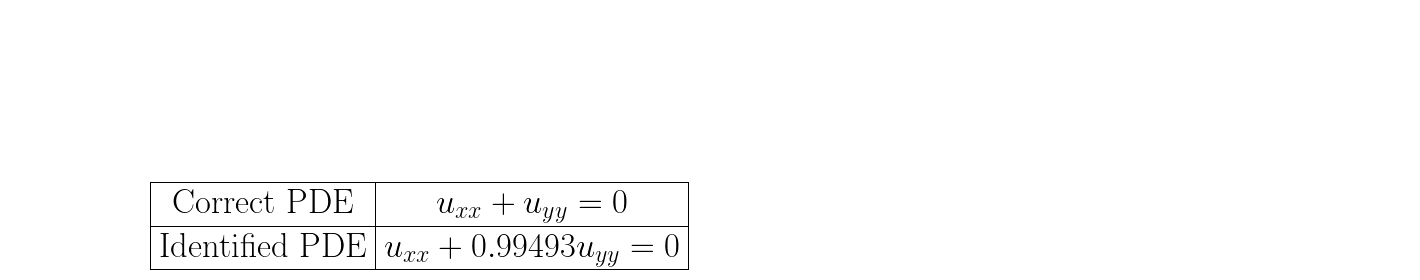

In [62]:
####### Row 3: Identified PDE ##################    
lambda_1_value = model.lambda_1.detach().cpu().numpy()

fig = plt.figure(figsize=(14, 10))

gs2 = gridspec.GridSpec(1, 3)
gs2.update(top=0.25, bottom=0, left=0.0, right=1.0, wspace=0.0)

ax = plt.subplot(gs2[:, :])
ax.axis('off')

s1 = r'$\begin{tabular}{ |c|c| }  \hline Correct PDE & $u_{xx} + u_{yy} = 0$ \\  \hline Identified PDE & '
s2 = r'$u_{xx} + %.5f u_{yy} = 0$ \\  \hline ' % (lambda_1_value)
s3 = r'\end{tabular}$'
s = s1+s2+s3
ax.text(0.1, 0.1, s, size=25)

plt.show()